In [2]:
# -*- coding: utf-8 -*-
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings   
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [3]:
# pretty display of variables
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# Define Neural network
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
net.load_state_dict(torch.load('../models/untuned-mvp.pt'))
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
)

In [6]:
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())


Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([11, 84])
fc3.bias 	 torch.Size([11])


In [7]:
net.state_dict()['conv1.bias']

tensor([ 0.1158,  0.0227,  0.1451,  0.0033, -0.0611,  0.0731])

## Prep tweet image data

In [152]:
# Loading in data

class Food11Dataset(Dataset):
    """Food 11 dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.index_file = pd.read_csv(csv_file) # first column: image_name (i.e. 0809-personal.jpg)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.index_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.index_file.iloc[idx, 0]) # get filepath to image
        image = io.imread(img_name)
        label = self.index_file.iloc[idx, 1] # get the labels

        if self.transform:
            image = self.transform(image)

        return image, label

In [154]:
# Transforms
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w, 3)) ## ensure 3 channels

        return img


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return image


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return torch.from_numpy(image)

In [155]:
# Ready to load + transform images
my_transform = transforms.Compose([
                                   Rescale(64),
                                   RandomCrop(32),
                                   ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                   ])

In [9]:
def write_names(dir_name, csv_fn):
    '''Write file names in folder to csv.'''
    img_names  = os.listdir(dir_name)
    with open(csv_fn, 'w+') as f:
        f.write('img_name,label\n')
        for i in range(len(img_names)):
            img_name = img_names[i]
            img_label = '-1'
            row = f'{img_name},{img_label}\n'
            f.write(row)
write_names('../output/imgs/', '../output/tweet-imgs-index.csv')

In [156]:
tweetset = Food11Dataset(csv_file='../output/tweet-imgs-index.csv',
                         root_dir='../output/imgs/',
                        transform=my_transform)


In [157]:
tweetloader = DataLoader(tweetset, batch_size=4,
                         shuffle=False, num_workers=0) #num_workers=0 because can't parallelize in Windows
classes = ('bread', 'dairy-product', 'dessert', 'egg', 'fried-food', 'meat', 'noodles/pasta', 'rice', 'seafood', 'soup', 'vegetable', 'fruit') # tuple that I can index into

In [127]:
for i, (tweet_img, lbl) in enumerate(tweetset):
    if list(tweet_img.size()) != [3,32,32]:
        print(i, tweet_img.size())
    if i % 50 == 0:
        print('I am at ', i)

I am at  0
I am at  50
I am at  100
I am at  150
I am at  200
I am at  250
I am at  300
I am at  350
I am at  400
I am at  450
I am at  500
I am at  550
I am at  600
I am at  650
I am at  700
I am at  750
I am at  800
I am at  850
I am at  900
I am at  950
I am at  1000
I am at  1050
I am at  1100
I am at  1150
I am at  1200
I am at  1250
I am at  1300
I am at  1350
I am at  1400
I am at  1450


In [99]:
type(img)

torch.Tensor

torch.Size([4, 32, 32])


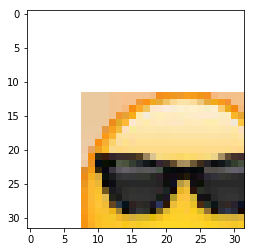

In [114]:
from skimage.color import rgba2rgb
img, lbl = tweetset[557]
# img = img[:3]
imshow(img)
print(img.size())
# print(img)
# img_rgb = rgba2rgb(img.transpose((1,2,0)))
# imshow(img)

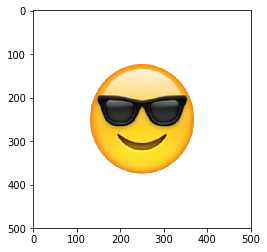

In [116]:
plt.imshow(io.imread('../output/imgs/DennysDiner-i455460447567609856.jpg'))

torch.Size([3, 32, 32])

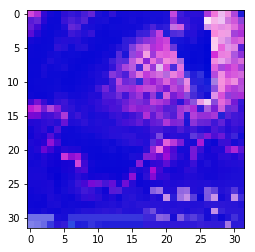

In [126]:
img, lab = tweetset[451]
img.size()
imshow(img)

In [19]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) ## move around the dimensions: # 3*32*32 --> 32*32*3

dessert dessert dessert bread


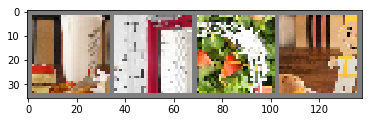

In [144]:
img_batch = iter(tweetloader)
imgs, _ = img_batch.next()
imshow(utils.make_grid(imgs))
# print(' '.join(classes[lbls[j]] for j in range(4))) ## -1 no label yet
outputs = net(imgs.float())
_, predicted = torch.max(outputs, 1)
print(' '.join(classes[predicted[j]] for j in range(4))) 

In [143]:
len(tweetset)

1480

In [149]:
print(' '.join(classes[Yhat[j]] for j in range(len(Yhat)))) 

dessert dessert dessert soup dessert dessert dessert dessert dessert dessert soup dessert soup dessert dessert soup meat dessert dessert soup dessert soup seafood seafood soup soup soup dessert soup soup meat meat meat meat dessert meat dessert dessert dessert dessert dessert egg meat egg dessert dessert dessert egg egg dessert dessert dessert dessert dessert dessert dessert egg dessert seafood dessert egg egg soup dessert dessert dessert meat dessert dessert dessert dessert dessert dessert soup dessert soup dessert dessert meat dessert dessert meat dessert dessert dessert dessert dessert dessert dessert meat dessert dessert seafood seafood dessert dessert soup dessert dessert dessert egg meat dessert dessert dessert egg soup dessert dessert soup dessert dessert dessert dessert meat egg dessert dessert soup soup dessert dessert soup dessert


In [147]:
print(' '.join(classes[Yhat[j]] for j in range(len(Yhat)))) 

soup dessert dessert soup dessert dessert dessert dessert dessert seafood soup bread soup dessert dessert soup dessert dessert dessert soup meat soup seafood dessert egg dessert soup dessert soup soup dessert dessert dessert dessert dessert meat dessert dessert dessert dessert meat egg dessert egg dessert dessert dessert dessert egg dessert dessert dessert dessert egg dessert dessert egg egg dessert dessert dessert egg meat dessert dessert dessert dessert dessert dessert soup dessert meat dessert dessert dessert soup dessert dessert meat dessert soup meat dessert dessert dessert meat dessert egg dessert dessert dessert dessert soup seafood dessert egg dessert dessert dessert soup egg dessert dessert dessert dessert egg soup dessert dessert meat dessert soup dessert dessert meat soup dessert dessert dessert dessert meat egg soup dessert dessert dessert meat soup


In [158]:
# get all predicted values
Yhat = torch.tensor([], dtype=torch.long)
with torch.no_grad():
    for i_batch, data in enumerate(tweetloader):
        images, labels = data
        outputs = net(images.float())
        _, predicted = torch.max(outputs.data, 1)
        Yhat = torch.cat((Yhat, predicted))
        
        if i_batch % 25 == 0:
            print(Yhat.size())

torch.Size([4])
torch.Size([104])
torch.Size([204])
torch.Size([304])
torch.Size([404])
torch.Size([504])
torch.Size([604])
torch.Size([704])
torch.Size([804])
torch.Size([904])
torch.Size([1004])
torch.Size([1104])
torch.Size([1204])
torch.Size([1304])
torch.Size([1404])


In [131]:
Yhat.size()

torch.Size([1480])

In [159]:
Yhat.size()

torch.Size([1480])

In [160]:
def write_predicted(dir_name, csv_fn):
    '''Write file names in folder to csv.'''
    img_names  = os.listdir(dir_name)
    with open(csv_fn, 'w+') as f:
        f.write('img_name,label\n')
        for i in range(len(img_names)):
            img_name = img_names[i]
            img_label = Yhat[i]
            row = f'{img_name},{img_label}\n'
            f.write(row)
write_predicted('../output/imgs/', '../output/actual-nnet-out.csv')

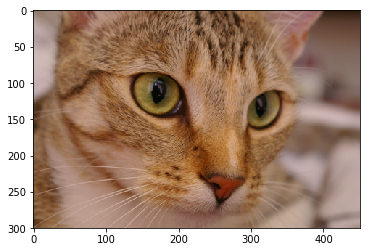

In [91]:
from skimage import data
cat = data.chelsea()
plt.imshow(cat)

In [94]:
cat

array([[[143, 120, 104],
        [143, 120, 104],
        [141, 118, 102],
        ...,
        [ 45,  27,  13],
        [ 45,  27,  13],
        [ 45,  27,  13]],

       [[146, 123, 107],
        [145, 122, 106],
        [143, 120, 104],
        ...,
        [ 46,  29,  13],
        [ 45,  29,  13],
        [ 47,  30,  14]],

       [[148, 126, 112],
        [147, 125, 111],
        [146, 122, 109],
        ...,
        [ 48,  28,  17],
        [ 49,  29,  18],
        [ 50,  30,  19]],

       ...,

       [[ 92,  58,  30],
        [105,  71,  43],
        [132,  98,  71],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[128,  92,  60],
        [139, 103,  71],
        [134,  95,  64],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[139, 103,  71],
        [127,  88,  57],
        [125,  86,  53],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

In [93]:
t_cat = torch.from_numpy(cat)
t_cat.size()
t_cat

torch.Size([300, 451, 3])

tensor([[[143, 120, 104],
         [143, 120, 104],
         [141, 118, 102],
         ...,
         [ 45,  27,  13],
         [ 45,  27,  13],
         [ 45,  27,  13]],

        [[146, 123, 107],
         [145, 122, 106],
         [143, 120, 104],
         ...,
         [ 46,  29,  13],
         [ 45,  29,  13],
         [ 47,  30,  14]],

        [[148, 126, 112],
         [147, 125, 111],
         [146, 122, 109],
         ...,
         [ 48,  28,  17],
         [ 49,  29,  18],
         [ 50,  30,  19]],

        ...,

        [[ 92,  58,  30],
         [105,  71,  43],
         [132,  98,  71],
         ...,
         [  0, 255,   0],
         [  0, 255,   0],
         [  0, 255,   0]],

        [[128,  92,  60],
         [139, 103,  71],
         [134,  95,  64],
         ...,
         [  0, 255,   0],
         [  0, 255,   0],
         [  0, 255,   0]],

        [[139, 103,  71],
         [127,  88,  57],
         [125,  86,  53],
         ...,
         [  0, 255,   0],
        

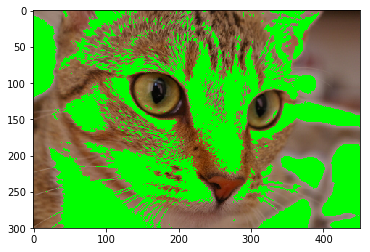

In [92]:
reddish = cat[:, :, 0] > 160
cat[reddish] = [0, 255,0]
plt.imshow(cat)